<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/M%C3%BC%C5%9Fteri_Davran%C4%B1%C5%9FAnaliziveSegmentasyonu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

. Müşteri Davranış Analizi ve Segmentasyonu
•	Amaç: Müşteri verilerini analiz ederek, davranışsal segmentasyon yapmak ve pazarlama stratejilerini optimize etmek.
•	Teknolojiler: Scikit-learn, K-means clustering, PCA (Principal Component Analysis).
•	Çıktı: Müşteri segmentasyonu ve kişiselleştirilmiş pazarlama kampanyaları için öneriler.


2. Gerekli Kütüphaneleri Yükleme
İlk hücreye aşağıdaki kodları yazalım:

In [ ]:
# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modülleri
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Diğer
from warnings import filterwarnings
filterwarnings('ignore')

3. Veri Setini Yükleme ve Keşifsel Veri Analizi
Örnek bir müşteri veri seti kullanacağız:

In [ ]:
# Veri setini yükleme (örnek olarak online retail dataset)
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
df = pd.read_excel('Online Retail.xlsx')

# İlk 5 satırı göster
df.head()

--2025-03-26 23:10:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [   <=>              ]  22.62M  50.6MB/s    in 0.4s    

2025-03-26 23:10:14 (50.6 MB/s) - ‘Online Retail.xlsx’ saved [23715344]



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Veri seti hakkında bilgi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Temel istatistikler
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


4. Veri Ön İşleme

In [ ]:
# Eksik değerleri temizleme
df.dropna(inplace=True)

# InvoiceNo'da 'C' olanları (iptal işlemler) kaldırma
df = df[~df['InvoiceNo'].astype(str).str.contains('C')]

# RFM metriklerini oluşturma
import datetime as dt

# Bugünün tarihini belirleme (veri setindeki en son tarihe 2 gün ekleyerek)
today_date = df['InvoiceDate'].max() + dt.timedelta(days=2)

# RFM hesaplamaları
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'UnitPrice': 'sum'  # Monetary
})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm['monetary'] > 0]

5. Veri Standardizasyonu


In [ ]:
# Log dönüşümü (skewness'i azaltmak için)
rfm_log = rfm.apply(lambda x: np.log1p(x))

# Standardizasyon
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

6. Optimal Küme Sayısını Belirleme


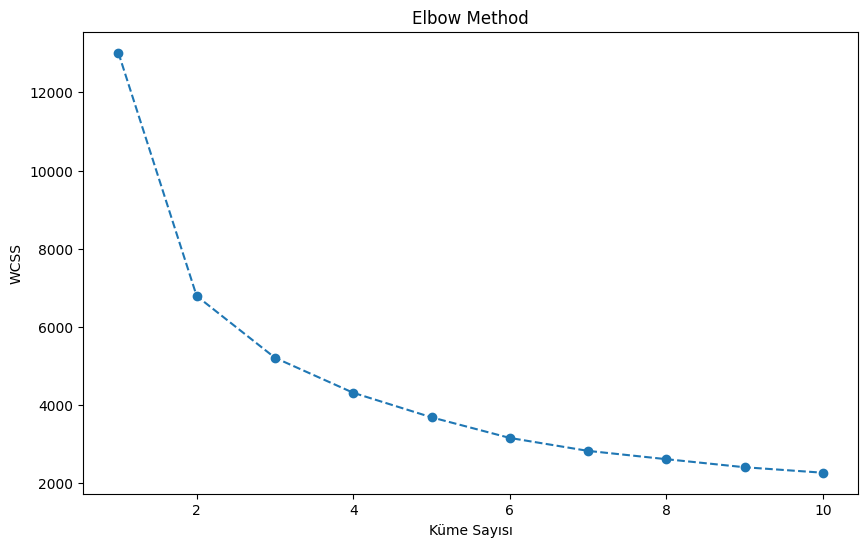

In [ ]:
# Elbow yöntemi
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

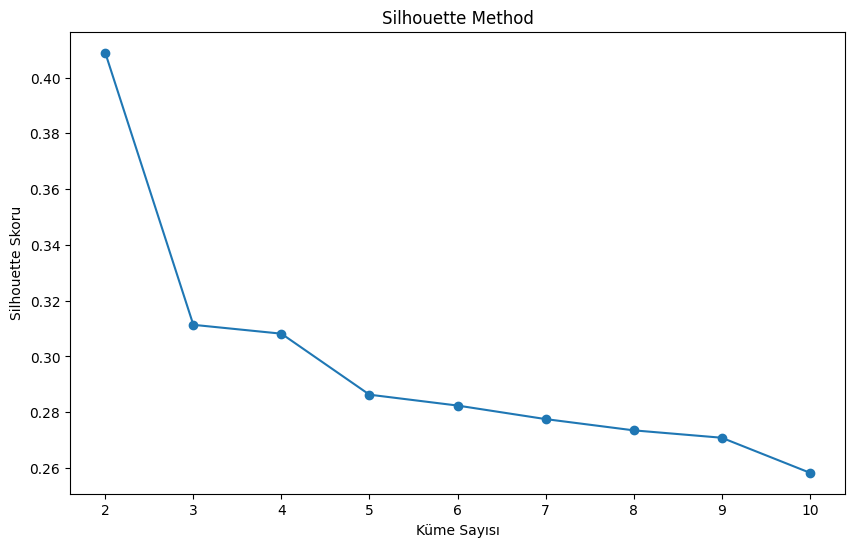

In [ ]:
# Silhouette skoru
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Küme Sayısı')
plt.ylabel('Silhouette Skoru')
plt.title('Silhouette Method')
plt.show()

7. K-Means Kümeleme Uygulama


In [ ]:
# Optimal küme sayısıyla model oluşturma
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Küme etiketlerini ekleme
rfm['cluster'] = clusters

8. PCA ile Boyut İndirgeme ve Görselleştirme


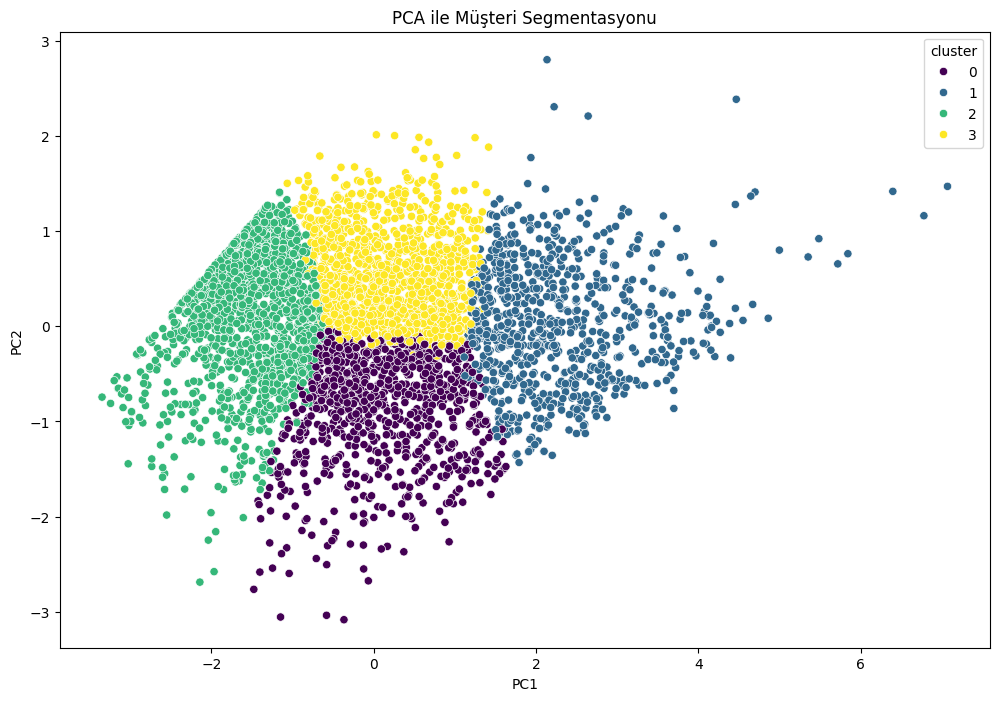

In [ ]:
# PCA uygulama
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(rfm_scaled)

# PCA sonuçlarını dataframe'e dönüştürme
pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters
pca_df['CustomerID'] = rfm.index

# Görselleştirme
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title('PCA ile Müşteri Segmentasyonu')
plt.show()

9. Küme Analizi ve Yorumlama


In [ ]:
# Kümelerin RFM metriklerine göre analizi
cluster_stats = rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(2)

cluster_stats

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0         19.11      2.37   115.72   893
1         15.26     12.65   905.96   830
2        184.96      1.27    52.32  1466
3         91.28      3.54   268.07  1149

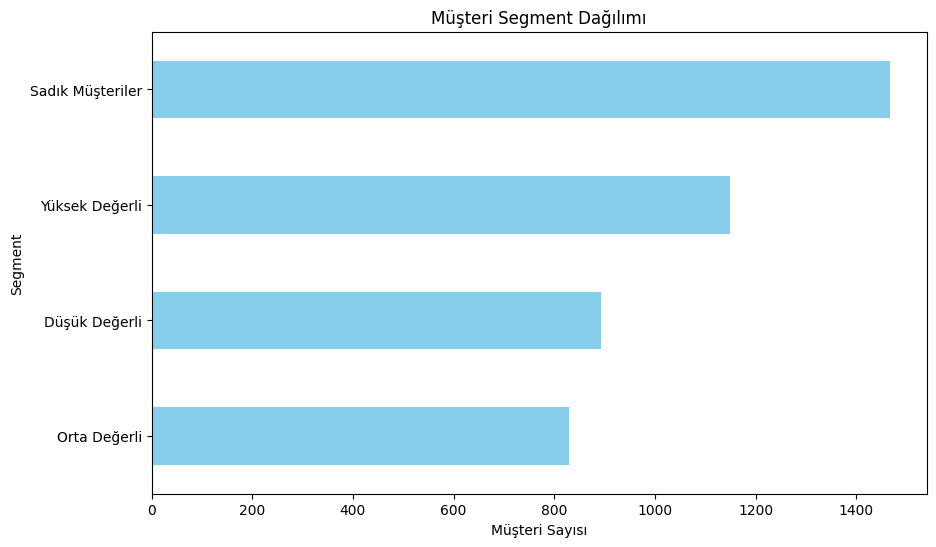

In [ ]:
# Kümeleri yorumlama ve isimlendirme
rfm['segment'] = rfm['cluster'].map({
    0: 'Düşük Değerli',
    1: 'Orta Değerli',
    2: 'Sadık Müşteriler',
    3: 'Yüksek Değerli'
})

# Segment dağılımı
segment_counts = rfm['segment'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10,6))
segment_counts.plot(kind='barh', color='skyblue')
plt.title('Müşteri Segment Dağılımı')
plt.xlabel('Müşteri Sayısı')
plt.ylabel('Segment')
plt.show()

10. Pazarlama Stratejisi Önerileri


In [ ]:
# Segmentlere özel pazarlama önerileri
strategies = {
    'Yüksek Değerli': '''
    - Özel VIP programları ve avantajlar sunun
    - Kişiselleştirilmiş ürün/hizmet önerileri
    - Sadakat programlarında ekstra puanlar
    - Doğrudan kişisel iletişim (özel müşteri temsilcisi)''',

    'Sadık Müşteriler': '''
    - Sık satın alma davranışını ödüllendirin
    - Yeniden satın alma teşvikleri (bir sonraki alışverişte indirim)
    - Topluluk oluşturma etkinlikleri
    - Özel günlerde kişiselleştirilmiş mesajlar''',

    'Orta Değerli': '''
    - Çapraz satış ve ek ürün önerileri
    - Paket indirimleri ve toplu alım avantajları
    - Sadakat programına katılım teşviki
    - E-posta pazarlama kampanyaları''',

    'Düşük Değerli': '''
    - Yeniden etkileşim kampanyaları (unutturma mesajları)
    - Hoş geldin indirimleri ve promosyonlar
    - Düşük bütçeli ürün önerileri
    - Sosyal medya reklamlarıyla hatırlatma'''
}

for segment, strategy in strategies.items():
    print(f'### {segment} Müşteriler İçin Stratejiler:')
    print(strategy)
    print('\n')

### Yüksek Değerli Müşteriler İçin Stratejiler:

    - Özel VIP programları ve avantajlar sunun
    - Kişiselleştirilmiş ürün/hizmet önerileri
    - Sadakat programlarında ekstra puanlar
    - Doğrudan kişisel iletişim (özel müşteri temsilcisi)


### Sadık Müşteriler Müşteriler İçin Stratejiler:

    - Sık satın alma davranışını ödüllendirin
    - Yeniden satın alma teşvikleri (bir sonraki alışverişte indirim)
    - Topluluk oluşturma etkinlikleri
    - Özel günlerde kişiselleştirilmiş mesajlar


### Orta Değerli Müşteriler İçin Stratejiler:

    - Çapraz satış ve ek ürün önerileri
    - Paket indirimleri ve toplu alım avantajları
    - Sadakat programına katılım teşviki
    - E-posta pazarlama kampanyaları


### Düşük Değerli Müşteriler İçin Stratejiler:

    - Yeniden etkileşim kampanyaları (unutturma mesajları)
    - Hoş geldin indirimleri ve promosyonlar
    - Düşük bütçeli ürün önerileri
    - Sosyal medya reklamlarıyla hatırlatma




11. Sonuçları Kaydetme


In [ ]:
# Sonuçları CSV olarak kaydetme
rfm.to_csv('customer_segmentation_results.csv')

# PCA sonuçlarını da kaydedebiliriz
pca_df.to_csv('pca_results.csv')